# R package: MatchIt

R package Matchitを使った傾向スコアマッチング(Propensity score matching). Matchitは1500件近い引用数があり広く使われている様子。

Propensity scoreの概要については [Propensity scoreの図解まとめ](https://www.slideshare.net/kaz_yos/propensity-score) がわかりやすい。

引用元
1. [MatchIt:  Nonparametric Preprocessing forParametric Causal Inference](https://imai.fas.harvard.edu/research/files/matchit.pdf) by Ho et al.
2. [Tutorial of propensity score matching](https://sejdemyr.github.io/r-tutorials/statistics/tutorial8.html) by Simon Ejdemyr
3. [A Step-by-Step Guide to Propensity Score Matching in R](https://pareonline.net/pdf/v19n18.pdf) by Randolph et al.
4. [Matching as Nonparametric Preprocessing for Reducing Model Dependence in Parametric Causal Inference](https://gking.harvard.edu/files/matchp.pdf) by Ho et al.

## Libraries

In [1]:
library(MatchIt)
library(ggplot2)
library(dplyr)
library(tidyr)
library(useful)
library(patchwork)

Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## テストデータの読み込み

Randolph et al.で使われていたデータ([リンク](hhttp://justusrandolph.net/psm/newyork.csv))を使う。ニューヨークの学校のサイズ(tot)、少数人種の割合(min)、昼食の料金補助を受けている学生の割合(dis)、School to watchであるかどうか(stw, 1=True, 0=False)。

一定の教育水準を満たした学校を国が"Schools to watch"と指定されいるらしい [?](https://www.imlea.org/domain/45)。

In [2]:
mat = read.table("newyork.csv", sep = ",", header = T, row.names = 1, stringsAsFactors = F, comment.char = "", quote = "")
head(mat)

,tot,min,dis,stw
,<int>,<dbl>,<dbl>,<int>
SKANEATELES MIDDLE SCHOOL,380,0.03,0,0
MARCUS WHITMAN MIDDLE SCHOOL,276,0.04,0,0
BLIND BROOK-RYE MIDDLE SCHOOL,376,0.09,0,0
BRONXVILLE MIDDLE SCHOOL,404,0.11,0,0
BRIARCLIFF MIDDLE SCHOOL,374,0.12,0,0
RYE MIDDLE SCHOOL,754,0.17,0,0


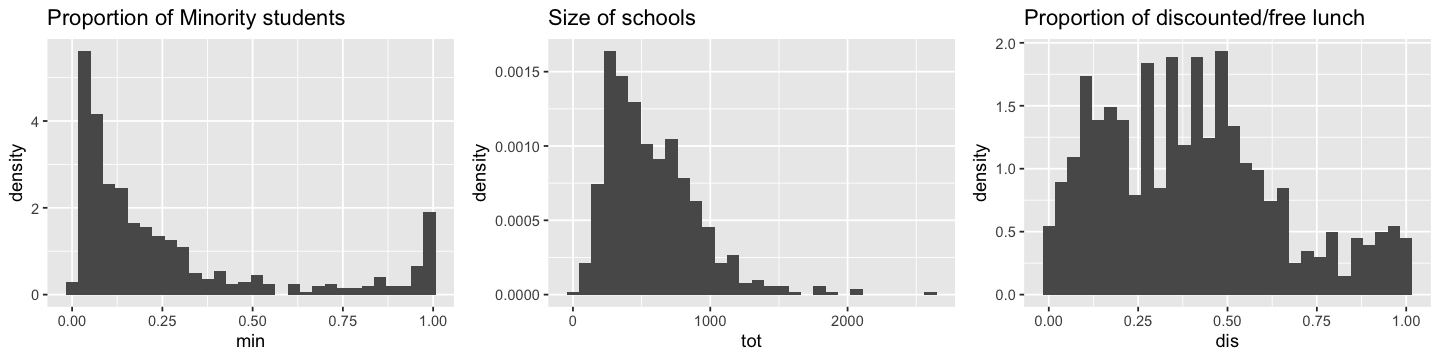

In [9]:
options(repr.plot.width=12, repr.plot.height=3)
fig1 = ggplot(mat) + geom_histogram(aes(x=min, y=..density..), bins=30) + ggtitle("Proportion of Minority students")
fig2 = ggplot(mat) + geom_histogram(aes(x=tot, y=..density..), bins=30) + ggtitle("Size of schools")
fig3 = ggplot(mat) + geom_histogram(aes(x=dis, y=..density..), bins=30) + ggtitle("Proportion of discounted/free lunch")
fig1 + fig2 + fig3

In [10]:
table(mat$stw)


  0   1 
559  25 

## Propensity score matching

理論的背景は文献4が詳しい。
ある副作用が激しい治療を受けるかどうかを患者1~nが選択したケースを考える。このとき患者iに現れる治療効果$y_i$は以下の様なモデルで表すことができる。(文献1)

$$
    y_i = t_i y_i(1) + (1 - t_i) y_i(0)
$$

このとき$y_i(0), y_i(1)$は患者iが治療を受けない/受けた場合の治療効果であり、$t_i$は患者iが実際に治療を受けたかどうか(True=1, False=0)を表す変数である。

このとき治療の効果を推定する際に治療を受けたグループと受けていないグループの間で効果量$y_i$ (e.g. 5年後に生存しているか, 投与後がんマーカーの存在量) の群間比較を行うのは誤りである。なぜなら、副作用が激しい治療を選ぶかどうかは、治療前の患者の状態$X_i$によるからである。次の様な統計量ATE(Average treatment effect)やATT(ATE on treated samples)を求めることが期待される。(文献4)

$$
    ATE = \frac{1}{n} \sum_{i=1}^{n}E[Y_i(1) - Y_i(0) | X_i]
$$
$$
    ATT = \frac{1}{\sum_{i=1}^{n}t_i} \sum_{i=1}^{n}t_iE[Y_i(1) - Y_i(0) | X_i]
$$

しかし当然であるが患者iの投与時$Y_i(1)$と非投与時$Y_i(0)$のデータが両方揃っているわけがないので、これをうまく推定するのがこの手法である。

Under construction...


Propensity scoreの計算方法はいたってシンプル。ロジスティック回帰で投与群/非投与群を分けるモデルを作り、そのモデルに従ってこれによって「投与群らしさ」のスコアを全患者に割り当てる。Rで実装すると以下の様になる。(文献2)

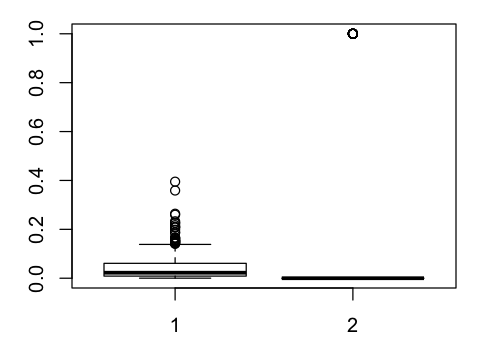

In [29]:
model = glm(stw ~ tot + min + dis, family = binomial(), data = mat)
ps = predict(model, data=mat, type="response")

options(repr.plot.width=4, repr.plot.height=3)
par(mar=c(3,3,1,1))
boxplot(ps,mat$stw)

MatchItでは上記の計算を簡便に行うための関数が用意されているので、これを使ってみる。

Propensity scoreを使ったマッチングの方法はいくつか存在しており、関数matchitのオプションmethodでいくつかの手法を選択することができる。
* nearest: Nearest neighbor matching
* subclass: Subclassification
* etc...

In [30]:
m.out = matchit(stw ~ tot + min + dis, data=mat, method="nearest", ratio=1) # 1:1 nearest neighbor matching
m.out


Call: 
matchit(formula = stw ~ tot + min + dis, data = mat, method = "nearest", 
    ratio = 1)

Sample sizes:
          Control Treated
All           559      25
Matched        25      25
Unmatched     534       0
Discarded       0       0


In [34]:
m.out$model; model # MatchItでも同様のロジスティック回帰モデルが使われていることがわかる


Call:  glm(formula = formula, family = binomial(logit), data = data)

Coefficients:
(Intercept)          tot          min          dis  
  -2.590820     0.001439    -1.214602    -4.693531  

Degrees of Freedom: 583 Total (i.e. Null);  580 Residual
Null Deviance:	    206.5 
Residual Deviance: 175.9 	AIC: 183.9


Call:  glm(formula = stw ~ tot + min + dis, family = binomial(), data = mat)

Coefficients:
(Intercept)          tot          min          dis  
  -2.590820     0.001439    -1.214602    -4.693531  

Degrees of Freedom: 583 Total (i.e. Null);  580 Residual
Null Deviance:	    206.5 
Residual Deviance: 175.9 	AIC: 183.9

Matchingのサマリーを関数plot等で表示することが可能(あまり美しくはないが)

[1] "To identify the units, use first mouse button; to stop, use second."


integer(0)

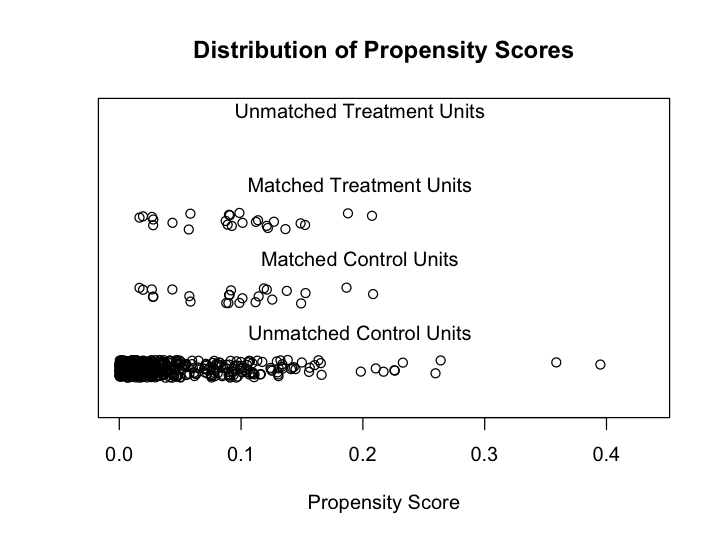

In [40]:
options(repr.plot.width=6, repr.plot.height=4.5)
plot(m.out, type="jitter")

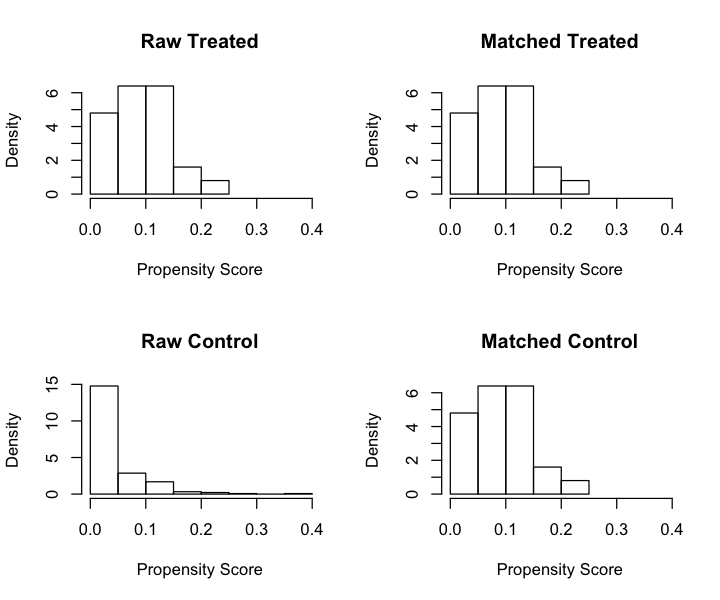

In [43]:
options(repr.plot.width=6, repr.plot.height=5)
plot(m.out, type="hist")

In [35]:
mat.matched = match.data(m.out)
head(mat.matched)

,tot,min,dis,stw,distance,weights
,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
RYE MIDDLE SCHOOL,754,0.17,0.00,0,0.15290145,1
PAUL J GELINAS JUNIOR HIGH SCHOOL,976,0.12,0.03,0,0.18655370,1
ALBERT G PRODELL MIDDLE SCHOOL,622,0.10,0.04,0,0.11870633,1
PIERSON MIDDLE/HIGH SCHOOL,530,0.19,0.06,0,0.08783631,1
MANHASSET MIDDLE SCHOOL,587,0.23,0.06,0,0.09055436,1
ACCOMPSETT MIDDLE SCHOOL,756,0.09,0.07,0,0.12559034,1
